Procedure:
1. Split data into labeled and unlabeled 
2. Train model on labeled
3. Define partition of labeled that will be removed due to privacy regulations
4. Select the partition of unlabeled that maintains accuracy and consistency


Methods
1. Label data that the model is the most uncertain about (close to 0.5)
2. If labels are skewed, label what we predict to be in the minority class


In [137]:
# LOAD LIBRARIES
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Load libraries for Decision Tree
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# Load libraries for Decision Tree Model Plot
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

# Load libaries for various model performance metrics
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve
from matplotlib import pyplot as plt
from inspect import signature

# Load libaries for logistic regression
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set()
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

from scipy.spatial import distance

In [2]:
# DATA IMPORT
data = pd.read_csv('creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# DATA PREPARATION
# All functions below assume first column to be label and rest of columns to be features
is_fraud = data.Class
prepared_data = data.drop(columns=['Class'])
prepared_data.insert(0, 'is_fraud', is_fraud)

In [140]:
FINAL_TEST_SET_FRACTION = 0.2
UNLABELED_FRACTION = 0.5
TRAIN_FRACTION = 0.75
DELETE_FRACTION = 0.1

In [158]:
# DEFINE FUNCTIONS
def split_method_final_test(data, seed = 300):
    method_set = data.sample(frac =1-FINAL_TEST_SET_FRACTION, random_state = seed)
    final_test_set = data.drop(method_set.index)
    
    return method_set, final_test_set

def split_labeled_unlabeled(data, seed = 200):
    labeled = data.sample(frac =1-UNLABELED_FRACTION, random_state = seed)
    unlabeled = data.drop(labeled.index)
    
    return labeled, unlabeled

def split_train_test(data, seed = 150):
    train = data.sample(frac=TRAIN_FRACTION,random_state=seed)
    test = data.drop(train.index)
    
    train_y = train.iloc[:,0]
    train_x = train.drop(train.columns[0], axis=1)
    
    test_y = test.iloc[:,0]
    test_x = test.drop(test.columns[0], axis=1)

    return train_x, train_y, test_x, test_y

def split_keep_delete(data, seed = 100):
    keep = data.sample(frac=1-DELETE_FRACTION, random_state = seed)
    delete = data.drop(keep.index)
    
    return keep, delete

def train_tree(data):    
    train_x, train_y, test_x, test_y = split_test_train(data)
    
    # Create Decision Tree classifer object
    clf = DecisionTreeClassifier(min_samples_leaf = 5, min_impurity_decrease = 0.000001)

    # Train Decision Tree Classifer
    clf = clf.fit(train_x,train_y)

    #Predict the response for test dataset
    predict_y = clf.predict(test_x)
    
    feature_names = train_x.columns
    class_names = train_y.unique()
    
    #plot_tree(clf, feature_names, class_names)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(test_y, predict_y))
    print(confusion_matrix(test_y, predict_y))
    plot_tree_ROC(clf, test_x, test_y)
    plot_tree(clf, feature_names, class_names)
    
    y_scores = clf.predict_proba(test_x)[:,1]

    
    average_precision = average_precision_score(test_y, y_scores)
    print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
    
    precision, recall, _ = precision_recall_curve(test_y, y_scores)
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))

def plot_tree(clf, feature_names, class_names):
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names = feature_names,class_names=['0','1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png('tree.png')
    display(Image(graph.create_png()))
    
def plot_tree_ROC(clf, test_x, test_y):
    prob_predictions = clf.predict_proba(test_x)
    print('AUC: ' + str(roc_auc_score(test_y, prob_predictions[:,1])))

    fpr, tpr, _ = roc_curve(test_y, prob_predictions[:,1])

    plt.clf()
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
def train_logistic_regression(data, prints = True):
    train_x, train_y, test_x, test_y = split_test_train(data)

    lr = LogisticRegression()
        
    lr.fit(train_x, train_y)
    
    if prints:
        print('Coefficients: ', lr.coef_)
        print('Interecept: ', lr.intercept_)

        predict_y = lr.predict(test_x)
        print('Confusion matrix: ', '\n', confusion_matrix(test_y, predict_y))
    
    return lr


In [159]:
def label_uncertain_data(lr, unlabeled, number_of_new_points):
    unlabeled_x = unlabeled.drop(unlabeled.columns[0], axis=1)
    prob_predictions = lr.predict_proba(unlabeled_x)
    prob_for_1 = prob_predictions[:,1]
    
    unlabeled['abs_uncertainty'] = np.abs(prob_for_1 - 0.5)
    #unlabeled.abs_uncertainty.plot.hist()
    
    new_data = unlabeled.sort_values('abs_uncertainty').iloc[0:number_of_new_points]
    new_data = new_data.drop(columns = 'abs_uncertainty')
    
    return new_data

In [160]:
def active_learning(active_learning_method = 'uncertainty', seeds = [200, 150, 100]):
    method_data, final_test = split_method_final_test(prepared_data, seed = seeds[0])
    labeled, unlabeled = split_labeled_unlabeled(method_data, seed = seeds[1])
    keep, delete = split_keep_delete(labeled, seed = seeds[2])
    
    lr = train_logistic_regression(labeled, prints = False)
    
    number_of_new_points = len(delete)
    
    if active_learning_method == 'uncertainty':
        new_data = label_uncertain_data(lr, unlabeled, number_of_new_points)
    else:
        print('active_learning_method not defined')
        
    
    new_labeled = pd.concat([new_data, keep], axis = 0)
    
    new_lr = train_logistic_regression(new_labeled, prints = False)
    
    final_test_y = final_test.iloc[:,0]
    final_test_x = final_test.drop(final_test.columns[0], axis=1)

    
    original_predict = lr.predict(final_test_x)
    new_predict = new_lr.predict(final_test_x)

    original_F1 = f1_score(final_test_y, original_predict)
    new_F1 = f1_score(final_test_y, new_predict)
    
    return original_F1, new_F1    

In [164]:
f1s = []
ITERATIONS = 100
for i in range(ITERATIONS):
    print(str(round(100*i / ITERATIONS)) + '% complete')
    f1s.append(active_learning(seeds = [i, i+1, i+2]))
print('100% complete')

0% complete
1% complete
2% complete
3% complete
4% complete
5% complete
6% complete
7% complete
8% complete
9% complete
10% complete
11% complete
12% complete
13% complete
14% complete
15% complete
16% complete
17% complete
18% complete
19% complete
20% complete
21% complete
22% complete
23% complete
24% complete
25% complete
26% complete
27% complete
28% complete
29% complete
30% complete
31% complete
32% complete
33% complete
34% complete
35% complete
36% complete
37% complete
38% complete
39% complete
40% complete
41% complete
42% complete
43% complete
44% complete
45% complete
46% complete
47% complete
48% complete
49% complete
50% complete
51% complete
52% complete
53% complete
54% complete
55% complete
56% complete
57% complete
58% complete
59% complete
60% complete
61% complete
62% complete
63% complete
64% complete
65% complete
66% complete
67% complete
68% complete
69% complete
70% complete
71% complete
72% complete
73% complete
74% complete
75% complete
76% complete
77% compl

In [167]:
pd.DataFrame(f1s).to_csv('F1scores.csv')

In [ ]:
active_learning()

In [168]:
import multiprocessing

In [169]:
multiprocessing.cpu_count()

8

In [117]:
labeled, unlabeled = split_labeled_unlabeled(prepared_data)

In [118]:
keep, delete = partition_to_delete(labeled)

In [119]:
lr = train_logistic_regression(labeled)

Coefficients:  [[-9.18379631e-05  1.01112388e-01 -2.39362019e-01 -6.22746571e-01
   1.38724738e-01 -3.67548981e-02 -7.05981069e-02 -1.39173215e-02
  -4.45737126e-02 -3.36889793e-01 -1.82940294e-01 -9.12134002e-02
   9.15483281e-03 -2.25536156e-01 -6.16468152e-01 -1.26095923e-01
  -2.07662270e-01 -3.61303740e-01 -1.38991370e-02  6.43120487e-02
   2.69917501e-02  8.82716336e-02  1.25319870e-01  1.88070700e-02
  -2.57435119e-02 -9.00183479e-02  1.10614154e-02 -2.48635141e-02
   2.28019281e-02 -9.35404355e-03]]
Interecept:  [-0.61137765]
Confusion matrix:  
 [[28414    16]
 [   19    32]]


In [120]:
unlabeled_x = unlabeled.drop(columns = ['is_fraud'])
prob_predictions = lr.predict_proba(unlabeled_x)
fraud_probas = prob_predictions[:,1]

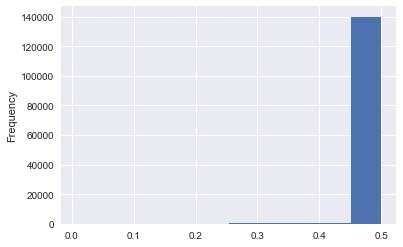

In [121]:
unlabeled['abs_uncertainty'] = np.abs(fraud_probas - 0.5)
unlabeled.abs_uncertainty.plot.hist()

In [122]:
new = unlabeled.sort_values('abs_uncertainty').iloc[0:len(delete)]
new = new.drop(columns = 'abs_uncertainty')

In [130]:
new.is_fraud.value_counts()[1] / (new.is_fraud.value_counts().sum())

0.0051264044943820225

In [132]:
prepared_data.is_fraud.value_counts()[1] / (prepared_data.is_fraud.value_counts().sum())

0.001727485630620034

In [124]:
new_labeled = pd.concat([new, keep], axis = 0)
lr_new = train_logistic_regression(new_labeled)

Coefficients:  [[-9.47296579e-05  2.69030264e-02 -2.37897660e-01 -6.49479432e-01
   1.20828370e-01 -1.15377584e-01 -7.14406424e-02 -7.12024136e-02
   1.62042180e-03 -3.31207942e-01 -1.91537175e-01 -8.57882777e-02
  -2.15063490e-02 -2.15810187e-01 -6.00623055e-01 -1.26829245e-01
  -2.32240788e-01 -4.18638240e-01 -4.71151008e-02  4.68250249e-02
   2.39041122e-02  1.01570238e-01  1.28153738e-01  2.35713864e-02
  -2.36937949e-02 -9.01886072e-02  1.57092922e-02 -3.07905497e-02
   1.66560563e-02 -1.54748358e-02]]
Interecept:  [-0.63174909]
Confusion matrix:  
 [[28398    14]
 [   32    37]]


In [28]:
centroid = delete.mean()[1:]

In [53]:
d = unlabeled.drop(columns = ['is_fraud'])
distances = []
for i in range(len(unlabeled)):
    distances.append(distance.euclidean(centroid, d.iloc[i]))

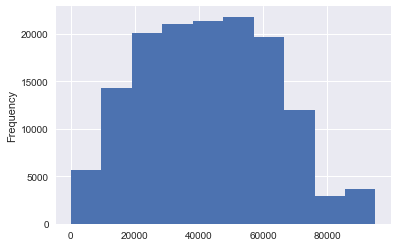

In [56]:
pd.Series(distances).plot.hist()

In [57]:
unlabeled['distance'] = distances

In [74]:
new = unlabeled.sort_values('distance').iloc[0:len(delete)]
new = new.drop(columns = ['distance'])

In [75]:
new_labeled = pd.concat([keep, new], axis = 0) # axis = 0 puts df on top of each other, axis = 1 puts df side by side

In [76]:
new.columns

Index(['is_fraud', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8',
       'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'Amount'],
      dtype='object')

In [77]:
train_logistic_regression(new_labeled)

Coefficients:  [[-8.58984654e-05  1.47100372e-01 -3.79074357e-01 -7.83133664e-01
   1.66160625e-01  2.16330472e-02 -7.73510688e-02  1.33017133e-01
  -1.85500619e-01 -3.79323818e-01 -2.02840553e-01 -1.54001781e-01
  -2.63427408e-02 -2.37689564e-01 -7.25375966e-01 -2.63053827e-01
  -2.46354041e-01 -3.96908410e-01  3.15097849e-02  6.03462478e-02
  -7.37931396e-03  1.57831099e-01  2.03047948e-01  2.73216491e-02
  -2.56249397e-02 -1.82337465e-01  3.06239715e-02 -5.66429047e-02
   1.74293266e-02 -7.54181874e-03]]
Interecept:  [-0.97280751]
Confusion matrix:  
 [[28416    14]
 [   16    35]]


In [33]:
from scipy.spatial import distance
distance.euclidean(centroid, d)

ValueError: Input vector should be 1-D.

In [80]:
# PCA
from sklearn.preprocessing import StandardScaler

x = prepared_data.drop(prepared_data.columns[0], axis=1)

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [84]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, prepared_data.iloc[:,0]], axis = 1)

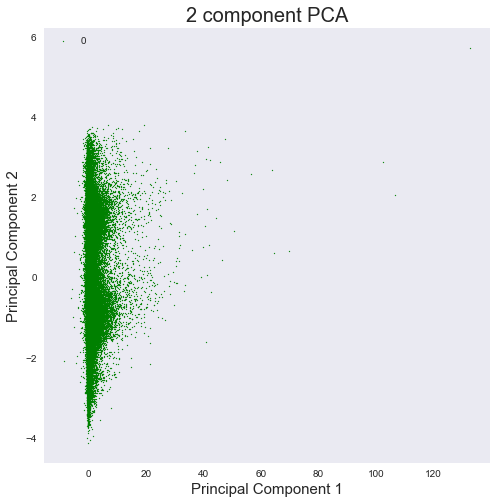

In [92]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0]
colors = ['g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['is_fraud'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 1)
ax.legend(targets)
ax.grid()


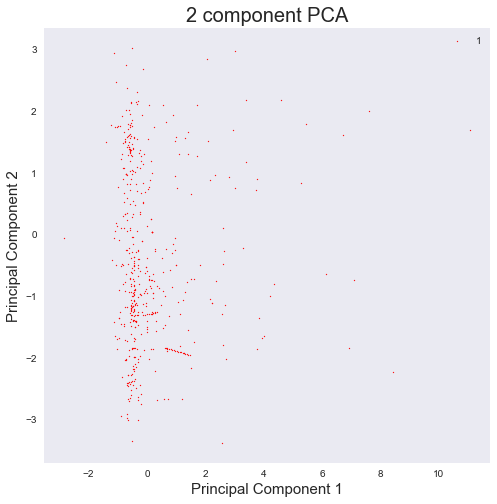

In [93]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [1]
colors = ['r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['is_fraud'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 1)
ax.legend(targets)
ax.grid()


In [94]:
pca.explained_variance_ratio_

array([0.06527312, 0.05611708])

Accuracy: 0.9992977774656788
[[28419    11]
 [    9    42]]
AUC: 0.9312601297993697


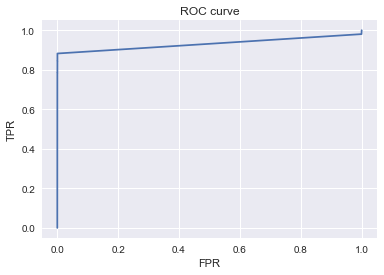

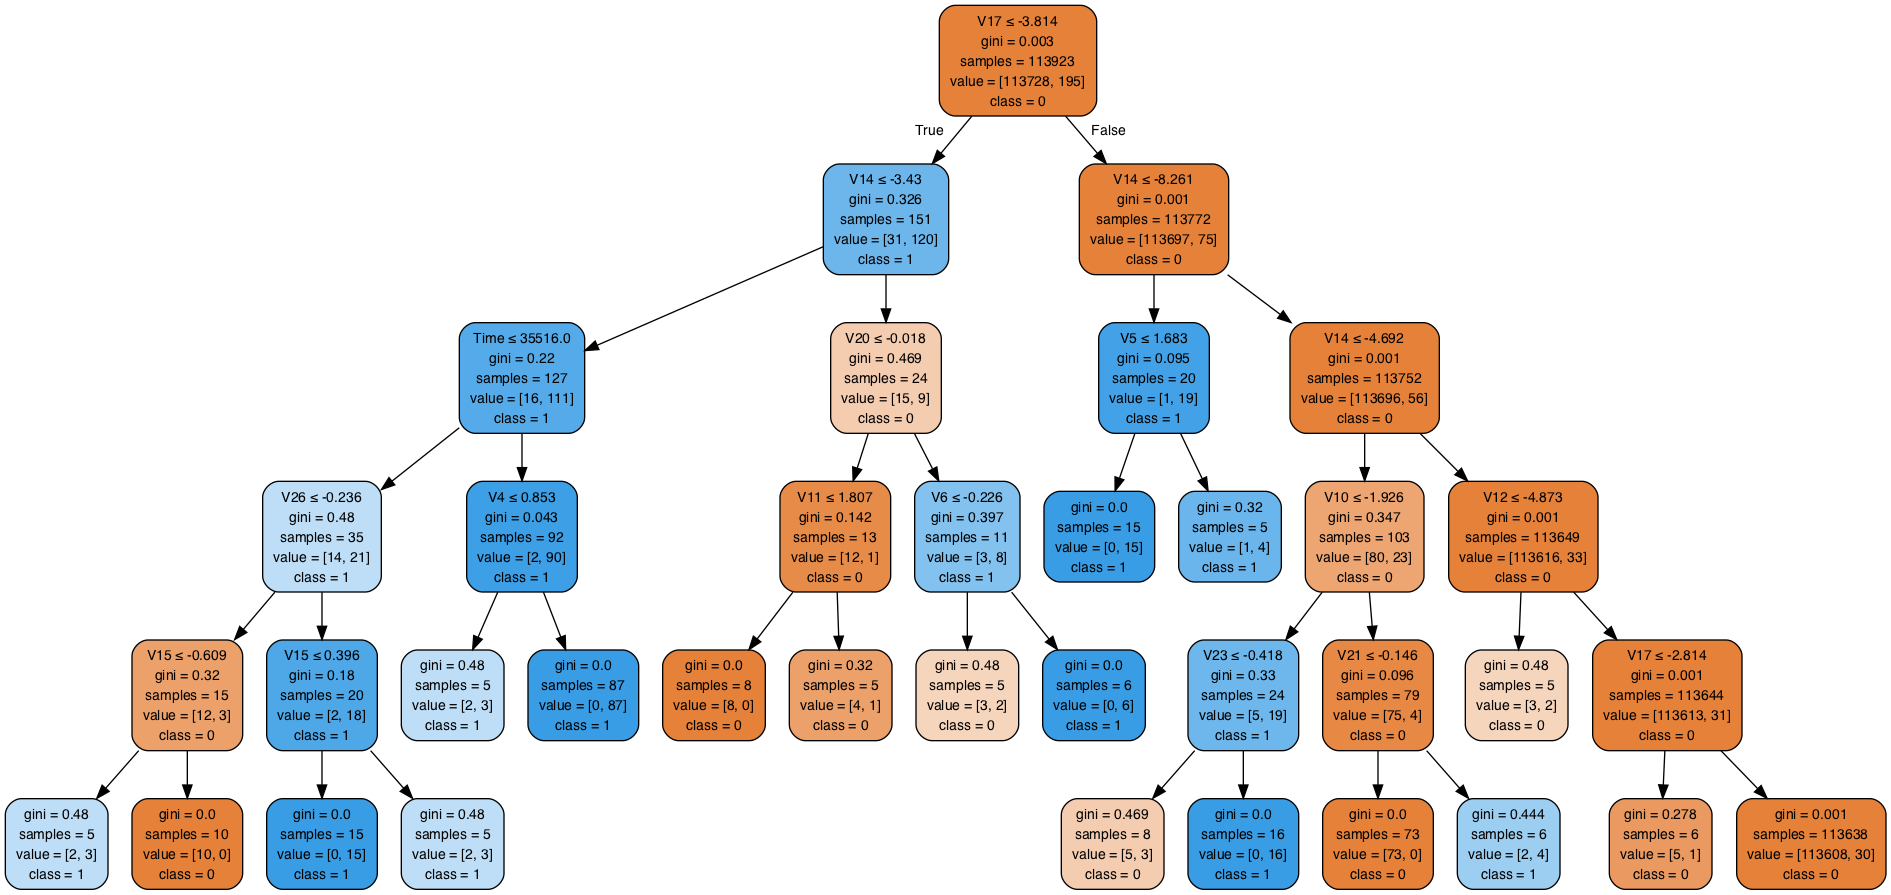

Average precision-recall score: 0.76
[[-9.18379631e-05  1.01112377e-01 -2.39362007e-01 -6.22746558e-01
   1.38724736e-01 -3.67549008e-02 -7.05981055e-02 -1.39173278e-02
  -4.45737075e-02 -3.36889785e-01 -1.82940289e-01 -9.12133978e-02
   9.15483582e-03 -2.25536151e-01 -6.16468134e-01 -1.26095916e-01
  -2.07662263e-01 -3.61303730e-01 -1.38991377e-02  6.43120469e-02
   2.69917484e-02  8.82716292e-02  1.25319865e-01  1.88070690e-02
  -2.57435111e-02 -9.00183431e-02  1.10614144e-02 -2.48635124e-02
   2.28019261e-02 -9.35404366e-03]]
[-0.61137762]
[[28414    16]
 [   19    32]]


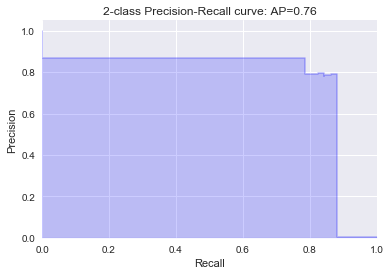

In [10]:
main(prepared_data)